<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Data Modeling
</div>

Dựa vào những gì đã phân tích, khám phá và nghiên cứu dữ liệu, tiếp theo ta sẽ huấn luyện một mô hình máy học có thể dự đoán được số điểm mà game đó đạt được dựa vào những thông tin đã cho trong game như thế nào.

## Import thư viện cần thiết

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, MinMaxScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import seaborn as sns
import pickle

<h3> Chúng ta sẽ nhìn lại tập dữ liệu sau quá trình tiền xử lý và khai thác </h3>

In [32]:
cleaned_df = pd.read_csv('../data/processed_data.csv')

In [33]:
cleaned_df.head(10)

,Title,Genre,withDLC,isMature,Developer,Publisher,Languages,PositiveReviews,TotalReviews,NegativeReviews,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay,Rating
0,Baldur's Gate 3,"Adventure, RPG, Strategy",1.0,1.0,Larian Studios,Larian Studios,"English, French, German, Spanish - Spain, Poli...",7329.0,8630.0,1134.5,470000.0,0.10,306875.0,2023,8,3,0.82643
1,Counter-Strike 2,"Action, Free to Play",1.0,1.0,Valve,Valve,"English, Czech, Danish, Dutch, Finnish, French...",7329.0,8630.0,1134.5,0.0,0.00,0.0,2012,8,21,0.82643
2,Lethal Company,"Action, Adventure, Indie, Early Access",0.0,1.0,Zeekerss,Zeekerss,English,7329.0,8630.0,1134.5,142000.0,0.00,142000.0,2023,10,23,0.82643
3,Cyberpunk 2077,RPG,1.0,1.0,CD PROJEKT RED,CD PROJEKT RED,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,470000.0,0.50,306875.0,2020,12,9,0.82643
4,ELDEN RING,"Action, RPG",0.0,1.0,FromSoftware Inc.,FromSoftware Inc.,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,470000.0,0.40,306875.0,2022,2,24,0.82643
5,Apex Legends™,"Action, Adventure, Free to Play",0.0,0.0,Respawn Entertainment,Electronic Arts,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,0.0,0.00,0.0,2020,11,4,0.82643
6,Dota 2,"Action, Strategy, Free to Play",1.0,0.0,Valve,Valve,"English, Bulgarian, Czech, Danish, Dutch, Finn...",7329.0,8630.0,1134.5,0.0,0.00,0.0,2013,7,9,0.82643
7,Hogwarts Legacy,"Action, Adventure, RPG",1.0,0.0,Avalanche Software,Warner Bros. Games,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,470000.0,0.50,306875.0,2023,2,10,0.82643
8,Dead by Daylight,Action,1.0,1.0,Behaviour Interactive Inc.,Behaviour Interactive Inc.,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,230000.0,0.65,80500.0,2016,6,14,0.82643
9,Project Zomboid,"Indie, RPG, Simulation, Early Access",0.0,0.0,The Indie Stone,The Indie Stone,"English, French, Italian, German, Spanish - Sp...",7329.0,8630.0,1134.5,260000.0,0.33,174200.0,2013,11,8,0.82643


### Để có thể nhìn nhận rõ mối quan hệ giữa các cột lý tưởng để làm feature cho model và cột target **Rating**, ta sẽ dùng **Mutual Information** 

#### Ta nhận thấy cột '**Title**' chỉ đơn giản là các giá trị thể hiện tên của các trò chơi điện tử trong tập dữ liệu, ta có thể suy đoán nó không mang lại ý nghĩa hay mối quan hệ gì với cột target '**Rating**'

In [34]:
cleaned_df.drop(columns = ['Title'], inplace = True)

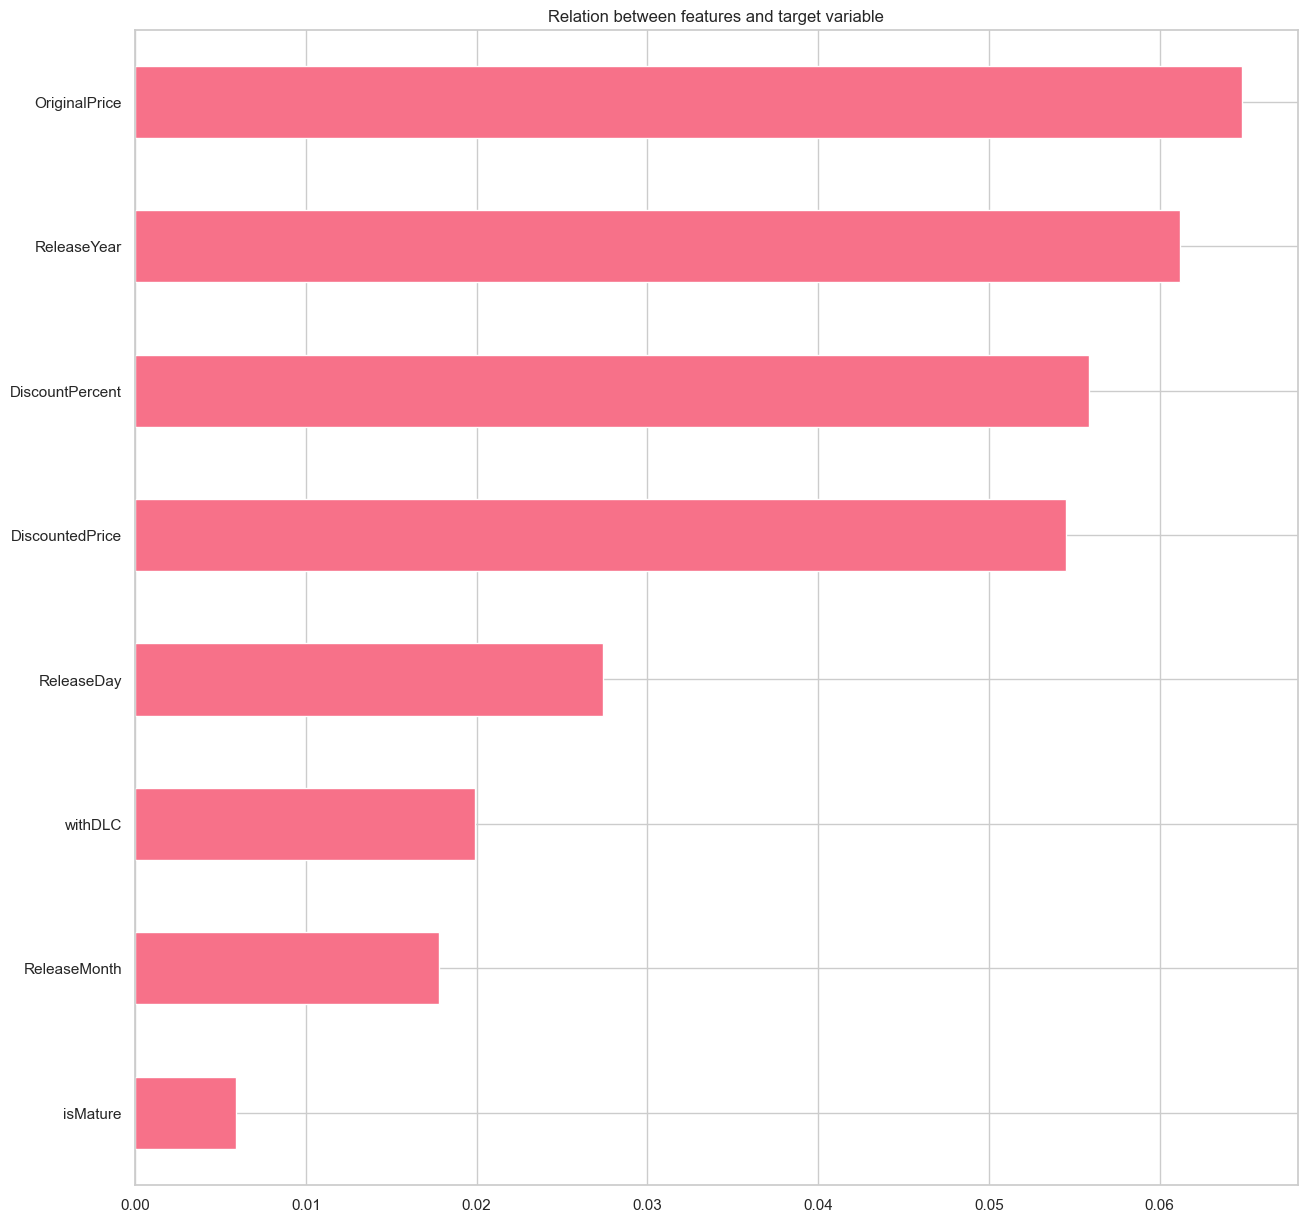

In [35]:
X = cleaned_df.drop(columns = ['Rating', 'PositiveReviews','NegativeReviews', 'TotalReviews'])
y = cleaned_df['Rating']
numeric_X = X.select_dtypes(include='number')
mi_scores = mutual_info_regression(numeric_X, y)
mi_scores = pd.Series(mi_scores, index = numeric_X.columns).sort_values(ascending = True)

plt.figure(figsize = (15, 15))
mi_scores.plot.barh()
plt.title('Relation between features and target variable')
plt.show()

## Pipeline cho bước tiền xử lí
Đầu tiên, ta sẽ tìm những cột dữ liệu không là kiểu dữ liệu số:

In [36]:
cat_df = cleaned_df.select_dtypes(include='object')
cat_df

,Genre,Developer,Publisher,Languages
0,"Adventure, RPG, Strategy",Larian Studios,Larian Studios,"English, French, German, Spanish - Spain, Poli..."
1,"Action, Free to Play",Valve,Valve,"English, Czech, Danish, Dutch, Finnish, French..."
2,"Action, Adventure, Indie, Early Access",Zeekerss,Zeekerss,English
3,RPG,CD PROJEKT RED,CD PROJEKT RED,"English, French, Italian, German, Spanish - Sp..."
4,"Action, RPG",FromSoftware Inc.,FromSoftware Inc.,"English, French, Italian, German, Spanish - Sp..."
...,...,...,...,...
9264,"Adventure, Casual, Indie, Simulation",Dirty Fox Games,Dirty Fox Games,English
9265,"Adventure, Casual, Indie",Suits & Sandals,Suits & Sandals,"English, Japanese"
9266,Action,Raven Software,id Software,English
9267,Action,[2.21],[2.21],English


Do `Genre` là cột mà mỗi sample có thể có một hoặc nhiều thể loại, do đó phương pháp encoding phù hợp nhất hiện tại là `One Hot Encoding`.
Ta có 2 cột `Developer` và `Publisher` là 2 cột không phải là dữ liệu số, ta sẽ tiến hành encode 2 cột này bằng `TargetEncoder`. Lí do không sử dụng One hot encoding do lo ngại việc quá nhiều cột ảnh hưởng đến hiệu năng của mô hình.

Ta scale các cột dữ liệu số cho model (Những cột có tiền tố `Genre` sẽ không được đưa vào vì nó là những cột `category` được encode, không phải là dữ liệu số thuần túy).

In [37]:
numeric_df = X.select_dtypes(include='number')
numeric_df

,withDLC,isMature,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay
0,1.0,1.0,470000.0,0.1,306875.0,2023,8,3
1,1.0,1.0,0.0,0.0,0.0,2012,8,21
2,0.0,1.0,142000.0,0.0,142000.0,2023,10,23
3,1.0,1.0,470000.0,0.5,306875.0,2020,12,9
4,0.0,1.0,470000.0,0.4,306875.0,2022,2,24
...,...,...,...,...,...,...,...,...
9264,1.0,1.0,73500.0,0.0,73500.0,2023,12,2
9265,1.0,0.0,73500.0,0.9,7350.0,2020,11,29
9266,0.0,0.0,112500.0,0.7,33750.0,1998,3,27
9267,0.0,0.0,87500.0,0.0,87500.0,1996,7,31


In [115]:
# Lấy những cột categorical và numerical
cat_cols = cat_df.columns
numeric_cols = numeric_df.columns
        
# Pipeline xử lý cho các cột category
target_encode_transformer = Pipeline(steps= [('TargetEncoder', TargetEncoder())])
onehot_encode_transformer = Pipeline( steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))])

# Pipeline xử lý cho các cột numeric
numeric_transfomer = Pipeline(steps= [('scaler', MinMaxScaler())])  # scale các giá trị về miền giá trị trong khoảng 0 đến 1 


# Pipeline cho quá trình tiền xử lí
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_transformer', onehot_encode_transformer, [cat_cols[0], cat_cols[3]]), # Sử dụng One Hot Encoding cho cột Genre
        ('target_transformer', target_encode_transformer, list(cat_cols[1:3])), # Sử dụng Target Encoding cho Publisher và Developer
        ('numeric_transfomer', numeric_transfomer, list(numeric_cols)),
    ],
    remainder='passthrough'  # keep the non-transformed columns
)

#### Validation

Để có thể đánh giá được hiệu suất mô hình và tìm được mô hình tốt nhất cho dự án, đó chính là nhiệm vụ của cross-validation. Cross-validation giúp đảm bảo tính tổng quát của mô hình trên dữ liệu mới, giảm nguy cơ overfitting.

Ở đây ta sẽ sử dụng phương pháp **K-fold cross-validation** để chia dữ liệu ra thành K phần (fold) và mô hình được huấn luyện K lần. Mỗi phần dữ liệu trong tập dữ liệu huấn luyện sẽ được lấy làm tập kiếm tra:

In [116]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 100)
def Cross_val_scores(model, X_val, y_val):
    scores = -1 * cross_val_score(model, X_val, y_val, cv = cv, scoring = 'neg_mean_squared_error', error_score='raise')
    
    return scores.mean()

Ở đây để đánh giá và so sánh hiệu suất mô hình, ta lựa chọn những mô hình sau:
- Linear Regression
- Decision Tree
- Random Forest
- Gradient Boosting

In [117]:
models = [('Linear Regression', LinearRegression()), 
          ('Decision Tree', DecisionTreeRegressor()),
          ('Random Forest', RandomForestRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor())]

##### Features chứa Release Date

In [118]:
X = cleaned_df.drop(['Rating', 'PositiveReviews','NegativeReviews', 'TotalReviews'], axis = 1)
y = cleaned_df['Rating']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train

,Genre,withDLC,isMature,Developer,Publisher,Languages,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay
1957,RPG,1.0,0.0,Nihon Falcom,XSEED Games,"English, Japanese",310000.0,0.50,155000.0,2018,2,14
79,"Racing, Sports",1.0,0.0,Codemasters,Electronic Arts,"English, French, Italian, German, Spanish - Sp...",470000.0,0.70,306875.0,2023,6,15
6207,Indie,1.0,0.0,Kinemotik Studios,Andromeda Entertainment,"English, Japanese, Korean, Simplified Chinese",188000.0,0.30,131600.0,2022,12,19
7443,"Indie, Simulation",1.0,0.0,▲ Pyramid Games,Pyramid Games S.A.,"English, French, German, Simplified Chinese, P...",170000.0,0.75,42500.0,2020,11,12
5513,"Casual, Indie, Simulation",1.0,0.0,G-MODE,G-MODE,"English, Simplified Chinese, Traditional Chine...",73500.0,0.50,36750.0,2020,3,29
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,"Adventure, Indie",1.0,0.0,Half Past Yellow,Merge Games,"English, French, German, Spanish - Spain, Port...",366000.0,0.93,25620.0,2022,7,12
5191,"Casual, RPG, Simulation, Strategy",1.0,1.0,Reborn Entertainment,Reborn Entertainment,"English, Japanese, Simplified Chinese",45000.0,0.36,28800.0,2021,5,28
5390,"RPG, Simulation",1.0,0.0,Mistwall Studio,Mistwall Studio,"English, French, German, Spanish - Spain",470000.0,0.50,262500.0,2022,12,5
860,"Adventure, Indie, Simulation, Strategy",1.0,0.0,BEHEMUTT,HypeTrain Digital,"English, Portuguese - Brazil, French, Spanish ...",260000.0,0.30,182000.0,2023,6,22


In [120]:
performances = {} # dict used to store cross_val_scores of each model to examine

for name, model in models:
    multi_model_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', model)]
    )
    try:
        scores = Cross_val_scores(multi_model_pl, X_train, y_train)
        print(f"{name} cross-validated score:", scores)
        performances[name] = scores
    except ValueError as e:
        print("Error during cross-validation:", e)

Linear Regression cross-validated score: 0.007475939091895395
Decision Tree cross-validated score: 0.010896071515283347
Random Forest cross-validated score: 0.006588402152583326
Gradient Boosting cross-validated score: 0.006392564481637252


In [121]:
performances

{'Linear Regression': 0.007475939091895395,
 'Decision Tree': 0.010896071515283347,
 'Random Forest': 0.006588402152583326,
 'Gradient Boosting': 0.006392564481637252}

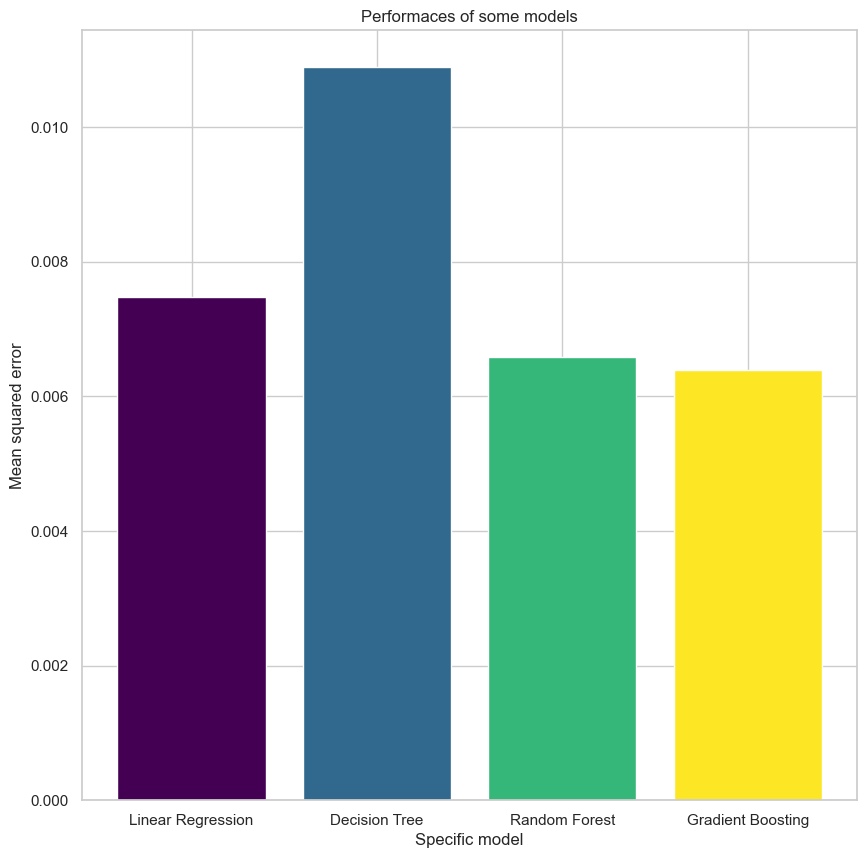

In [122]:
plt.figure(figsize = (10, 10))
colors = cm.viridis(np.linspace(0, 1, len(performances)))
plt.bar(performances.keys(), performances.values(), color = colors)
plt.xlabel('Specific model')
plt.ylabel('Mean squared error')
plt.title('Performaces of some models')
plt.show()

Dựa vào biểu đồ, ta thấy MSE trên từng model khá là chênh lệch, với MSE cao nhất là `Decision Tree` với khoảng 0.01 (lệch nhất trong 4 mô hình), 3 mô hình còn lại thì cho ra kết quả tương đối ngang nhau và thấp nhất là `Gradient Boosting` với MSE hơn 0.006 một chút.

**Kết luận:** Vậy ta chọn `Gradient Boosting` là mô hình chính cho project.

#### Ưu nhược điểm của Gradient Boosting:
1. Ưu điểm:
- Performance: là một mô hình mạnh, có thể xử lý với nhiều kiểu dữ liệu gồm các biến đầu vào kiểu số mang giá trị liên tục, hoặc kiểu categorical
- Flexibility: Gradient Boosting có thể tối ưu trên nhiều hàm mất mát và cung cấp nhiều lựa chọn tùy chỉnh siêu tham số để phù hợp nhất với mô hình
- No data pre-processing required: Thường yêu cầu khá ít hoặc không cần tiền xử lý thống kế dữ liệu, Gradient Boosting có sẵn khả năng để xử lý dữ liệu bị thiếu sót
- Handles non-linearities: Nó kết hợp các weak leaners để tạo thành mô hình có thể xử lý các mối quan hệ không tuyến tính giữa các features và target

2. Nhược điểm:
- Overfitting: Có thể bị overfit tập dữ liệu training khá nhanh, đôi lúc sẽ ít có khả năng diễn giải hơn các mô hình khác
- Computationally expensive: thường yêu cầu rất nhiều cây (> 1000) gây kiệt quệ bộ nhớ và thời gian
- Require careful tuning: hiệu suất của mô hình khá nhạy cảm với các siêu tham số của nó, yêu cầu nghiên cứu cẩn thận, kỹ lưỡng để tối ưu các siêu tham số (số cây, độ sâu của cây, learning_rate,...)
- Less interpretable: trong khi mỗi một cây quyết định thường dễ diễn giải và hiểu được, kết hợp nhiều cây lại khiến việc diễn giải trở nên khó nhằn vì dự đoán cuối cùng được đúc kết từ nhiều dự đoán của nhiều cây

##### TEST model on test set

In [123]:
xg_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('GradientBoostingRegressor', GradientBoostingRegressor())])

xg_pl.fit(X_train, y_train)
y_train_pred = xg_pl.predict(X_train)

In [124]:
y_test_pred = xg_pl.predict(X_test)
print(f'Train set: MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test set: MSE: {mean_squared_error(y_test, y_test_pred)}')

Train set: MSE: 0.003516452201034194
Test set: MSE: 0.005861728161520352


# 3. Fine tuning

Chúng ta đã xây dựng một mô hình **Gradient Boosting** để giải quyết vấn đề Machine Learning nhưng không quá ấn tượng với kết quả. Lựa chọn của chúng ta là gì? Bước đầu tiên của chúng ta là thu thập thêm dữ liệu và thực hiện **feature engineering**. Việc thu thập thêm dữ liệu và feature engineering thường mang lại lợi ích lớn nhất về mặt thời gian đầu tư so với hiệu suất được cải thiện, nhưng khi chúng ta đã sử dụng hết tất cả các nguồn dữ liệu, đã đến lúc chuyển sang điều chỉnh siêu tham số mô hình `Hyperparameter Tuning`. 

Xem xét qua các hyperparameter mặc định khi sử dụng mô hình `Random Forest` ở trên:

In [125]:
xg_pl.named_steps['GradientBoostingRegressor'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Chúng tôi sẽ điều chỉnh bộ hyperparameter sau:

- **n_estimators** = số lượng cây tuần tự được mô hình, tương đương với số lượng giai đoạn boosting để thực hiện
- **max_depth** = số cấp tối đa trong mỗi cây, giới hạn số lượng nút trong cây
- **learning_rate** = tham số co rút quy định tác động của mỗi cây lên kết quả cuối cùng
- **max_leaf_nodes** = số lượng nút lá tối đa của mỗi cây

### 3.1 Hyperparameter Grid
Trước tiên ta tạo một parameter grid để lấy mẫu trong khi thực hiện fit.

In [126]:
max_depth = [3, 4, 5]
max_leaf_nodes = [None, 5, 10, 20]
learning_rate = [0.01, 0.1, 0.2]
n_estimators = [50, 100, 150]
# Create the random grid
random_grid = {
    'GradientBoostingRegressor__n_estimators': n_estimators,
    'GradientBoostingRegressor__learning_rate': learning_rate,
    'GradientBoostingRegressor__max_depth': max_depth,
    'GradientBoostingRegressor__max_leaf_nodes': max_leaf_nodes
}
random_grid

{'GradientBoostingRegressor__n_estimators': [50, 100, 150],
 'GradientBoostingRegressor__learning_rate': [0.01, 0.1, 0.2],
 'GradientBoostingRegressor__max_depth': [3, 4, 5],
 'GradientBoostingRegressor__max_leaf_nodes': [None, 5, 10, 20]}

#### Tạo model dựa vào Pipeline được định nghĩa ở trên, với model đang xét là Random Forest

In [127]:
xg_Model = Pipeline(
    steps=[("preprocessor", preprocessor), ('GradientBoostingRegressor', GradientBoostingRegressor())])
xg_Model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_transformer',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genre', 'Languages']),
                                                 ('target_transformer',
                                                  Pipeline(steps=[('TargetEncoder',
                                                                   TargetEncoder())]),
                                                  ['Developer', 'Publisher']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['withDLC', 'isMature',
                                                   'OriginalPrice',
                                                   'DiscountPercent',
                                                   'DiscountedPrice',
                                                   'ReleaseYear',
                                                   'ReleaseMonth',
                                                   'ReleaseDay'])])),
                ('GradientBoostingRegressor', GradientBoostingRegressor())])

### 3.2 GridSearchCV
Đây là phương pháp đơn giản nhất của tinh chỉnh siêu tham số. Tất cả những gì bạn cần làm là xác định không gian grid search bao gồm tất cả những giá trị có thể của tham số đầu vào. Mô hình sẽ tìm kiếm một kết hợp siêu tham số tốt nhất dựa trên **MỌI** phép thử trong không gian grid search. Và tất nhiên phương pháp này rất tốn kém về chi phí tính toán nhưng bù lại giá trị tìm được đảm bảo là tốt nhất trong không gian grid search. 

In [128]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv_tuning = KFold(n_splits = 10, shuffle = True, random_state = 100)
xg_Grid = GridSearchCV(estimator = xg_Model, param_grid = random_grid, cv = cv_tuning, verbose=1, n_jobs = -1, error_score='raise')

# Fit the random search modl
xg_Grid.fit(X_train, y_train)

xg_Grid.best_params_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'GradientBoostingRegressor__learning_rate': 0.1,
 'GradientBoostingRegressor__max_depth': 5,
 'GradientBoostingRegressor__max_leaf_nodes': None,
 'GradientBoostingRegressor__n_estimators': 150}

In [130]:
xg_Grid.best_score_

0.1564286139996527

In [131]:
print(f'Train Accuracy: {xg_Grid.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {xg_Grid.score(X_test, y_test):.3f}')

Train Accuracy: 0.615
Test Accuracy: 0.211


### 3.3 Evaluation 
Evaluate model tốt nhất từ Grid Search

Đầu tiên ta define hàm evaluate

In [132]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [133]:
best_grid = xg_Grid.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0561 degrees.
Accuracy = 92.35%.


In [134]:
df_pred = pd.concat([y_test.reset_index(drop = True), pd.Series(best_grid.predict(X_test)), pd.Series(xg_pl.predict(X_test))], axis = 1)
df_pred.columns = ['y_test', 'y_fined_tune_pred', 'y_original_pred']
# df_pred
df_pred_sorted = df_pred.sort_values('y_test')

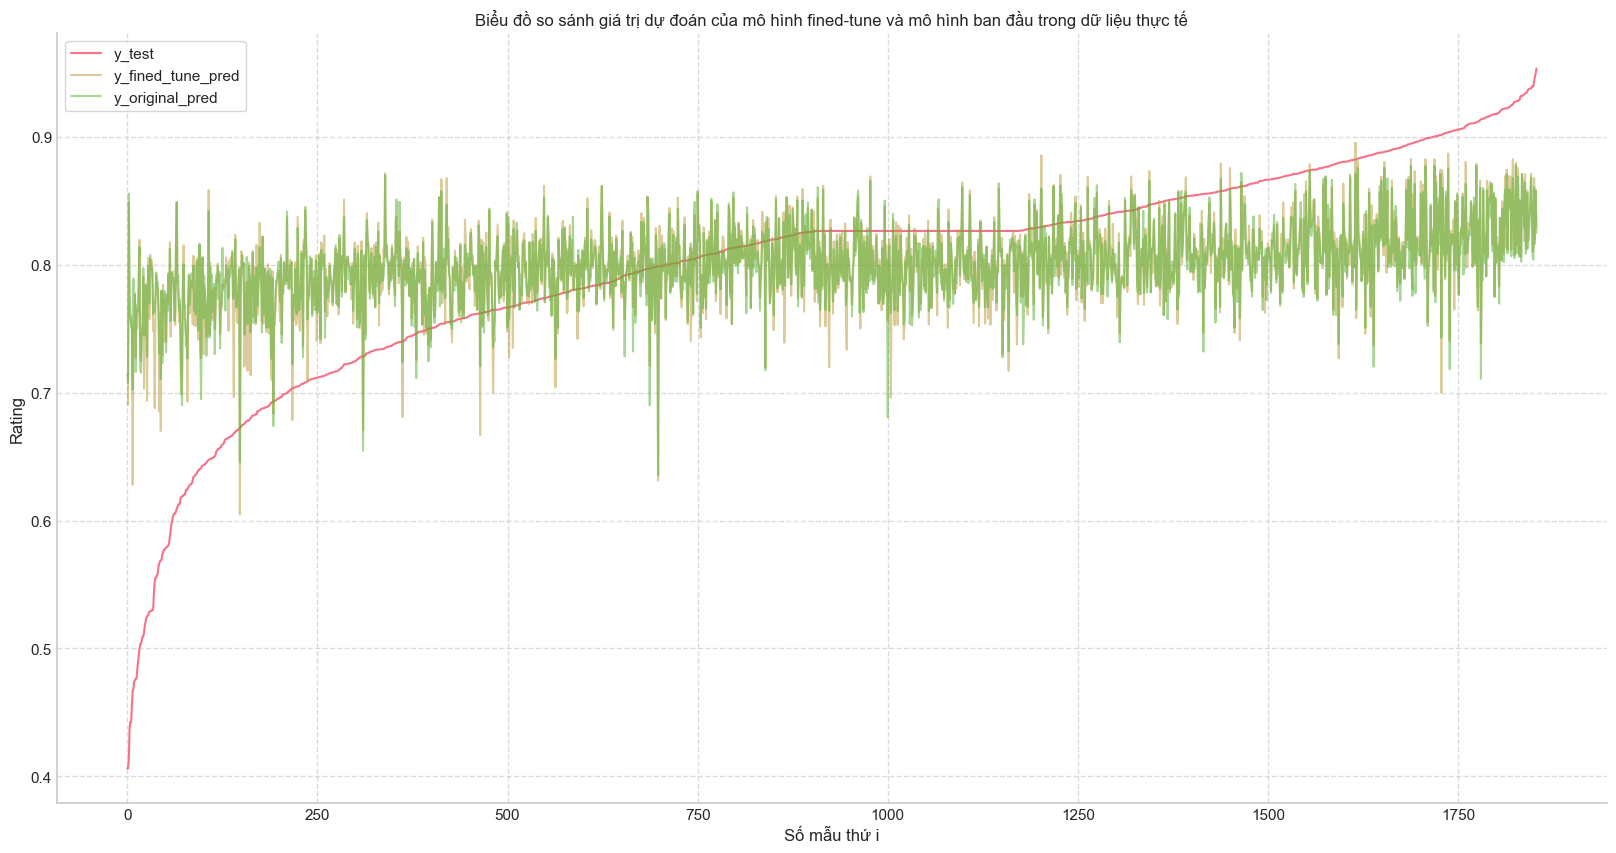

In [135]:
# Set Seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(20, 10))

# Use Seaborn's lineplot function
sns.lineplot(x=np.arange(0, len(df_pred_sorted['y_test'])), y=df_pred_sorted['y_test'], label='y_test', ax=ax)
sns.lineplot(x=np.arange(0, len(df_pred_sorted['y_fined_tune_pred'])), y=df_pred_sorted['y_fined_tune_pred'], alpha=0.5, label='y_fined_tune_pred', ax=ax)
sns.lineplot(x=np.arange(0, len(df_pred_sorted['y_original_pred'])), y=df_pred_sorted['y_original_pred'], alpha=0.5, label='y_original_pred', ax=ax)

# Set labels and title
ax.set_xlabel('Số mẫu thứ i')
ax.set_ylabel('Rating')
ax.set_title('Biểu đồ so sánh giá trị dự đoán của mô hình fined-tune và mô hình ban đầu trong dữ liệu thực tế')

# Show legend
ax.legend()

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Customize the tick parameters
ax.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.show()

Ta thấy có vẻ như mô hình sau khi đã fine tuning dự đoán cũng giống như mô hình ban đầu, và đường đi khá lệch với dữ liệu gốc, tuy nhiên nếu nhìn kĩ ta vẫn thấy xu hướng đi của nó khá tương đồng với xu hướng đi của dữ liệu thực tế.

## Triển khai mô hình:

In [137]:
pickle.dump(xg_Model, open('../deploy/model.pkl', 'wb'))